# Notebook for running Poisson Switching LDS with inputs
## Raveled patterns as encoding
## Stim ONLY trials, no behavior
## Number of output dimensions = 3
## Number of phases = 3

In [1]:
path = "/home/clewis/repos/realSpike/data/rb50_20250127/switching_plds/k3/"

In [2]:
from scipy.linalg import block_diag
import autograd.numpy as np
import matplotlib.pyplot as plt
import ssm

from pathlib import Path
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from real_spike.utils import get_spike_events, kalman_filter, bin_spikes, butter_filter, plot_dynamics_2d, plot_dynamics_3d
from matplotlib import colormaps
import pandas as pd
import h5py

from scipy.ndimage import gaussian_filter1d
from mpl_toolkits.mplot3d import Axes3D 

import random

%matplotlib inline

# Get data

In [3]:
f = h5py.File("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/MAT_FILES/rb50_20250127_datastruct_pt3.mat", 'r')
data = f['data']
print(data.keys())

<KeysViewHDF5 ['aligned_laser_rec_time', 'any', 'cue', 'cue_rec_time', 'cue_trial_time', 'field_id', 'field_size', 'full_field', 'grab', 'grab_ms', 'laser', 'laser_rec_time', 'laser_trial_time', 'lift', 'lift_ms', 'mouth', 'mouth_ms', 'no_success', 'pattern_fill', 'pattern_id', 'pattern_xy', 'single', 'totTime', 'trial_start']>


# Get stim only trials

In [4]:
stim_idxs = np.where(data["pattern_id"][:] > 2)[1]

# control_idxs = np.intersect1d(control_idxs, stim_idxs)
# con
stim_idxs = stim_idxs[stim_idxs > 150]
stim_idxs

array([151, 152, 153, 154, 155, 156, 157, 158, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206,
       207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 219, 220,
       221, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 246, 247, 248,
       249, 250, 251, 252, 253, 254, 256, 257, 258, 259, 260, 261, 262,
       263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275,
       276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 289,
       290, 291, 292, 294, 296, 297, 298, 299, 300, 301, 302, 303, 304,
       305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317,
       318, 319, 320, 321, 323, 324, 325, 326, 327, 328, 330, 331, 333,
       334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 34

In [5]:
np.unique(data["pattern_id"][0, stim_idxs])

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
       16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
       29.])

In [6]:
stim_idxs.shape

(269,)

## Get relevant time information

In [7]:
laser_times = data["aligned_laser_rec_time"]
laser_times.shape

(450, 1)

## Get the AP.bin file

In [8]:
from real_spike.utils import get_sample_data, get_meta
import tifffile

In [9]:
file_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/rb50_20250127_g0/rb50_20250127_g0_t0.imec0.ap.bin")
meta_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/rb50_20250127_g0/rb50_20250127_g0_t0.imec0.ap.meta")

In [10]:
meta_data = get_meta(meta_path)

In [11]:
ap_data = get_sample_data(file_path, meta_data)
ap_data.shape

(385, 166298223)

## Get conversion params

In [12]:
vmax = float(meta_data["imAiRangeMax"])
# get Imax
imax = float(meta_data["imMaxInt"])
# get gain
gain = float(meta_data['imroTbl'].split(sep=')')[1].split(sep=' ')[3])

In [13]:
vmax

0.6

In [14]:
imax

512.0

In [15]:
gain

500.0

# Get trials

In [16]:
def get_trials(idxs, bin_size):
    
    model_data = list()
    
    for i in tqdm(idxs):
        trial_no = i
        # get time points in ap space
        t = 50
        start_time = int((laser_times[trial_no, 0] - t) / 1_000 * 30_000)
        
        # get end of behavior = mouth (260ms) + 300ms 
        stim_t = 5
        t2 = 50
        end_time = int((laser_times[trial_no, 0] + stim_t + t2) / 1_000 * 30_000)
    
        trial = ap_data[:150, start_time:end_time]
    
        conv_data = 1e6 * trial / vmax / imax / gain
    
        filt_data = butter_filter(conv_data, 1_000, 30_000)
    
        c_start = int(laser_times[trial_no, 0] / 1_000 * 30_000)
        m_start = c_start - (30 * 2000)
        trial_median = ap_data[:150, m_start:c_start]
    
        trial_median = 1e6 * trial_median / vmax / imax / gain
        trial_median = butter_filter(trial_median, 1_000, 30_000)
        
        median = np.median(trial_median, axis=1)
    
        spike_ixs, counts = get_spike_events(filt_data, median)
        
        a = np.zeros((filt_data.shape[0], filt_data.shape[1]))
    
        for i, sc in enumerate(spike_ixs):
            a[i, sc] = 1
    
        b = bin_size * 30 # 30ms per bin
        binned_spikes = bin_spikes(a, b)

        model_data.append(np.asarray(binned_spikes.T, dtype=int))
        
    return model_data

In [17]:
bin_size = 1

In [18]:
# model_data = get_trials(stim_idxs, bin_size)

In [19]:
# save as a pickle file 
import pickle

In [20]:
filename = f"/home/clewis/repos/realSpike/data/rb50_20250127/plds_stim/{bin_size}ms_data.pkl"
# with open(filename, "wb") as file:
#     pickle.dump(model_data, file)

In [21]:
with open(filename, "rb") as file:
    model_data = pickle.load(file)

# Design the input matrix

In [22]:
# get the pattern types

In [23]:
p_ids = np.unique(data["pattern_id"][0, stim_idxs])

p_ids

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
       16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
       29.])

In [24]:
p_ids.shape

(27,)

## Get colors for plotting

In [25]:
c = [
    "maroon",
    "deeppink",
    "palevioletred", 
    "blue", 
    "orange", 
    "green", 
    "red", 
    "purple", 
    "brown", 
    "pink",
    "turquoise", 
    "olive", 
    "cyan", 
    "gold", 
    "lime", 
    "navy", 
    "magenta",
    "teal", 
    "royalblue", 
    "darkgreen",
    "dimgray",
    "darkgoldenrod",
    "midnightblue",
    "plum",
    "lime",
    "cadetblue",
    "steelblue",
    "peru"
]

In [26]:
len(c)

28

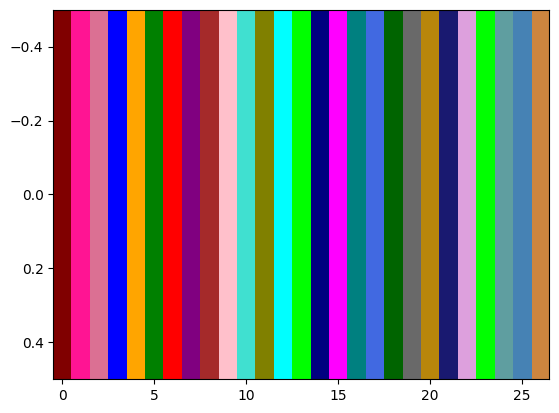

In [27]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap(c)

plt.imshow(np.arange(27).reshape(1,-1), aspect="auto", cmap=cmap)

# Create encodings 

##  Reconstruct patterns

In [28]:
mat = loadmat("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/MAT_FILES/rb50_20250127_datastruct_pt2.mat")
mat = mat['data']

print(mat.dtype.names)

('totTime', 'cue', 'laser', 'trial_start', 'cue_rec_time', 'cue_trial_time', 'laser_rec_time', 'laser_trial_time', 'field_size', 'pattern_xy', 'field_id', 'full_field', 'pattern_id', 'pattern_fill', 'lift_ms', 'lift', 'grab_ms', 'grab', 'mouth_ms', 'mouth', 'single', 'any', 'no_success')


In [29]:
data_struct = mat[0, 0]  # MATLAB structs are 2D arrays even if 1x1
data2 = {field: data_struct[field] for field in mat.dtype.names}

In [30]:
# visualize the patterns again
pattern_ids = list(np.unique(data2['pattern_id']))
len(pattern_ids)

30

In [31]:
from scipy.ndimage import zoom

In [32]:
reshape_size = 12

In [33]:
pattern_ids = list(np.unique(data2['pattern_id']))
all_patterns = list()
# pattern 0 = no laser
#all_patterns.append(np.zeros((12, 12)))
# pattern 1 = full field
#all_patterns.append(np.ones((12, 12)))
# pattern 2 = empty field 
#all_patterns.append(np.zeros((12, 12)))
for p_id in pattern_ids[3:]:
    ix = np.where(data2['pattern_id'] == p_id)[0][0].astype(np.int32)
    pattern = np.zeros((data2['pattern_xy'][ix][0].astype(np.int32), data2['pattern_xy'][ix][1].astype(np.int32)))
    # use the pattern fill to set elements to one
    object_ref = data2['pattern_fill'][0][ix]
    for x, y in zip(object_ref[:, 0], object_ref[:, 1]):
        pattern[x.astype(np.int32)-1, y.astype(np.int32)-1] = 1

    pattern = zoom(pattern, (reshape_size / pattern.shape[0], reshape_size / pattern.shape[1]), order=0)

    all_patterns.append(pattern)


In [34]:
len(all_patterns)

27

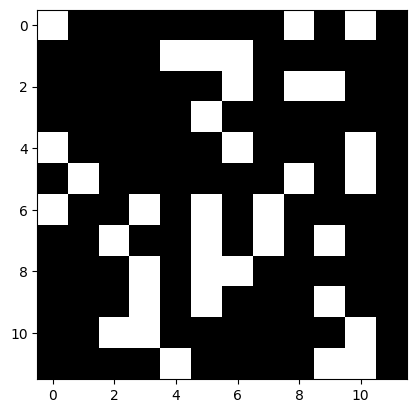

In [35]:
plt.imshow(all_patterns[0], cmap="binary")

In [36]:
model_data[0].shape

(105, 150)

In [37]:
inputs = list()
colors = list()
for i, d in zip(stim_idxs, model_data):
    # get the pattern id 
    p_id = int(data["pattern_id"][0][i]) - 3

    colors.append(c[p_id])

    encoding = all_patterns[p_id].ravel() 

    # stack the encoding for every timepoint (each bin)
    nput = np.zeros((d.shape[0], reshape_size**2))

    for z in range(5):
        nput[50 + z] = encoding

    inputs.append(nput)

In [38]:
inputs[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(105, 144))

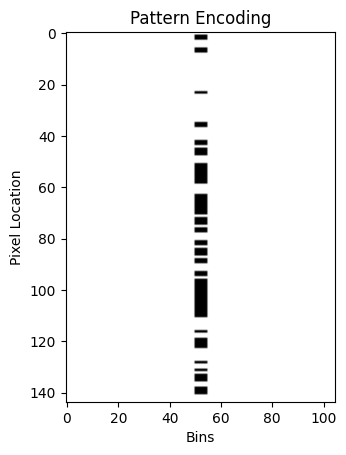

In [39]:
plt.imshow(inputs[0].T, cmap="binary")
plt.title("Pattern Encoding")
plt.xlabel("Bins")
plt.ylabel("Pixel Location")
plt.show()

# Fit the model

In [40]:
state_dim = 3
obs_dim = model_data[0].shape[1] 

plds = ssm.SLDS(N=obs_dim, K=3, D=state_dim, M=144, emissions="poisson", emission_kwargs=dict(link="softplus"))

elbos, q = plds.fit(model_data, inputs=inputs, method="laplace_em", num_iters=5)

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

# Visualize the results

In [41]:
# plot my elbos

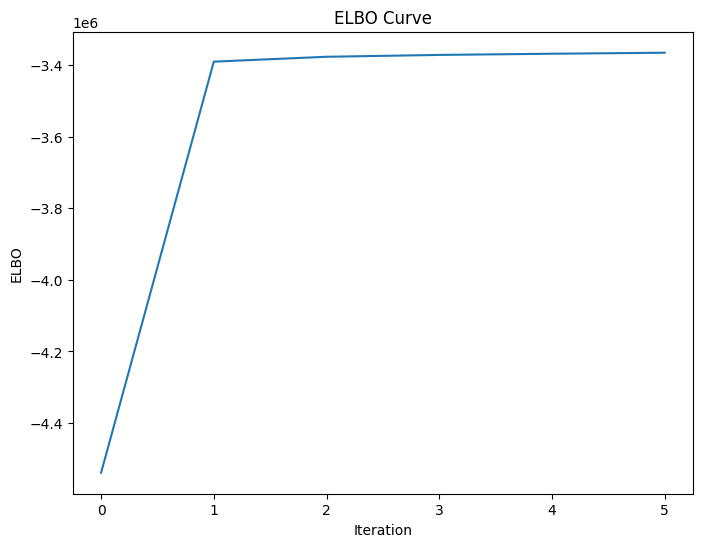

In [42]:
plt.figure(figsize=(8, 6))

plt.plot(elbos)

plt.xlabel("Iteration")
plt.ylabel("ELBO")

plt.title("ELBO Curve")

plt.show()

## Dynamics

In [43]:
As = plds.dynamics.As
As.shape

(3, 3, 3)

In [44]:
b = plds.dynamics.b
b.shape

(3,)

In [45]:
from matplotlib.patches import Patch

In [46]:
state_means = q.mean_continuous_states

In [47]:
custom_patches = [Patch(facecolor=c[int(i)-3], edgecolor='black', label=f'{int(i)}') for i in p_ids]

# Eigenvalue Decomposition on `A`

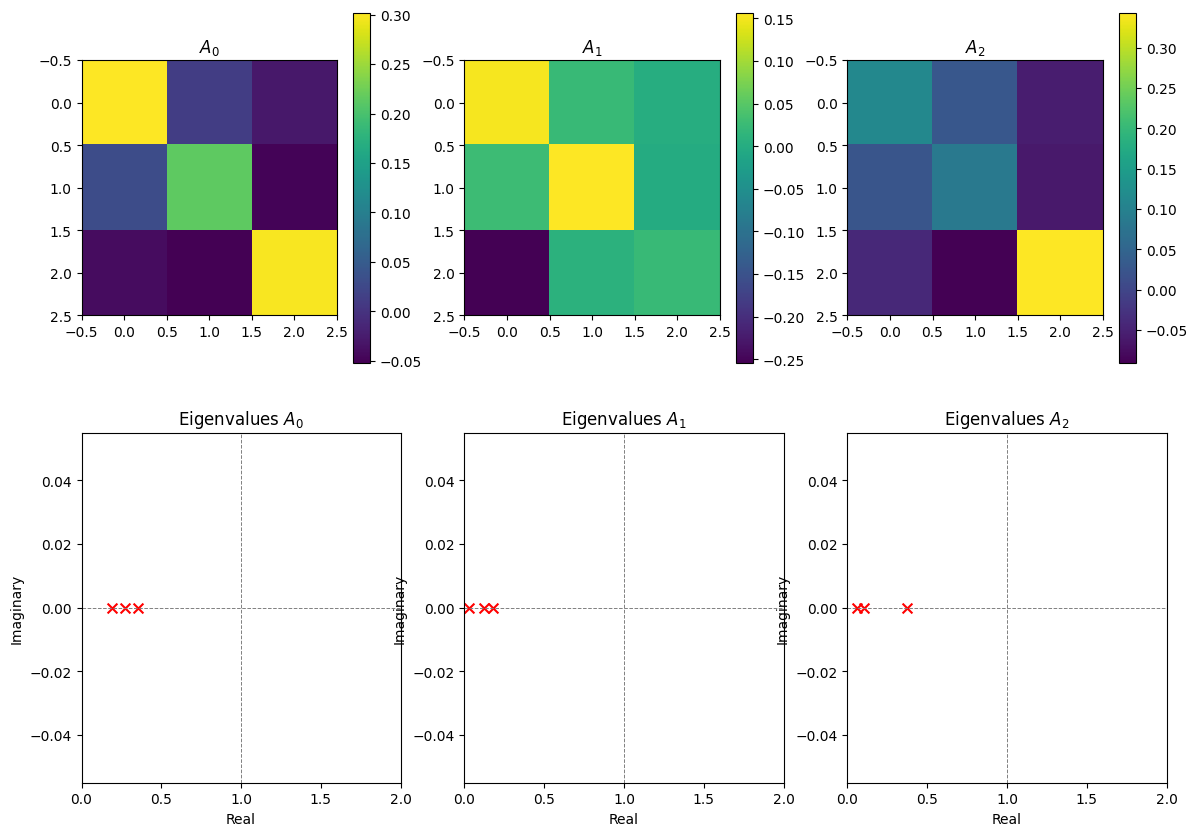

In [49]:
fig, axes = plt.subplots(2, 3, figsize=(14, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i in range(3):
    ax = axes[i]
    im = ax.imshow(As[i])
    ax.set_title(f"$A_{i}$")

    fig.colorbar(im, ax=ax) 

    eigvals, eigvecs = np.linalg.eig(As[i])
    axes[i+3].axhline(0, color='gray', linestyle='--', linewidth=0.7)
    axes[i+3].axvline(1, color='gray', linestyle='--', linewidth=0.7)

    a = np.exp(eigvals)
    #ax.colorbar()

    axes[i+3].scatter(eigvals.real, eigvals.imag, c='red', s=50, marker="x")

    axes[i+3].set_xlim((0, 2))
    
    axes[i+3].set_title(f"Eigenvalues $A_{i}$")
    
    axes[i+3].set_xlabel("Real")
    axes[i+3].set_ylabel("Imaginary")

plt.savefig(f"{path}A.png")

plt.show()

# Plot the dynamics for top-3 eigenvalue dims

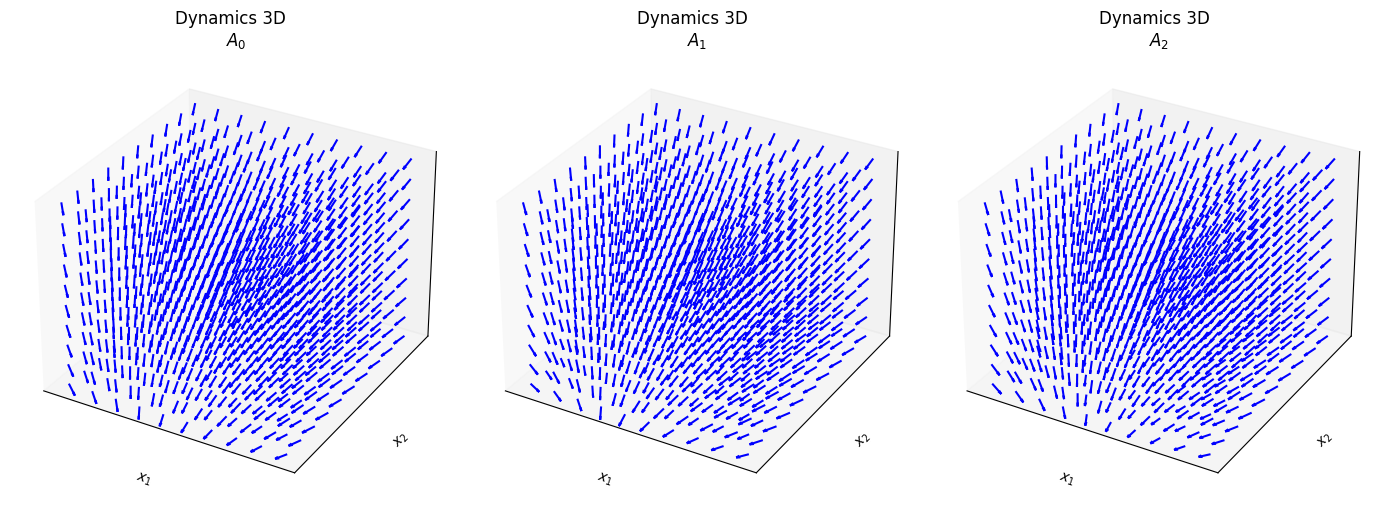

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(14, 10), subplot_kw={"projection": "3d"})

axes = axes.flatten()

for i in range(3):
    ax = axes[i]

    A_est = As[i]
    b_est = b


    plot_dynamics_3d(A_est, b_est, ax, npts=10, colors="blue")

    ax.set_title(f'Dynamics 3D \n $A_{i}$')
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_zlabel("$x_3$")

plt.tight_layout()

plt.savefig(f"{path}dynamics.png")
plt.show()

In [53]:
state_means[0].shape

(105, 3)

# Plot the state means 

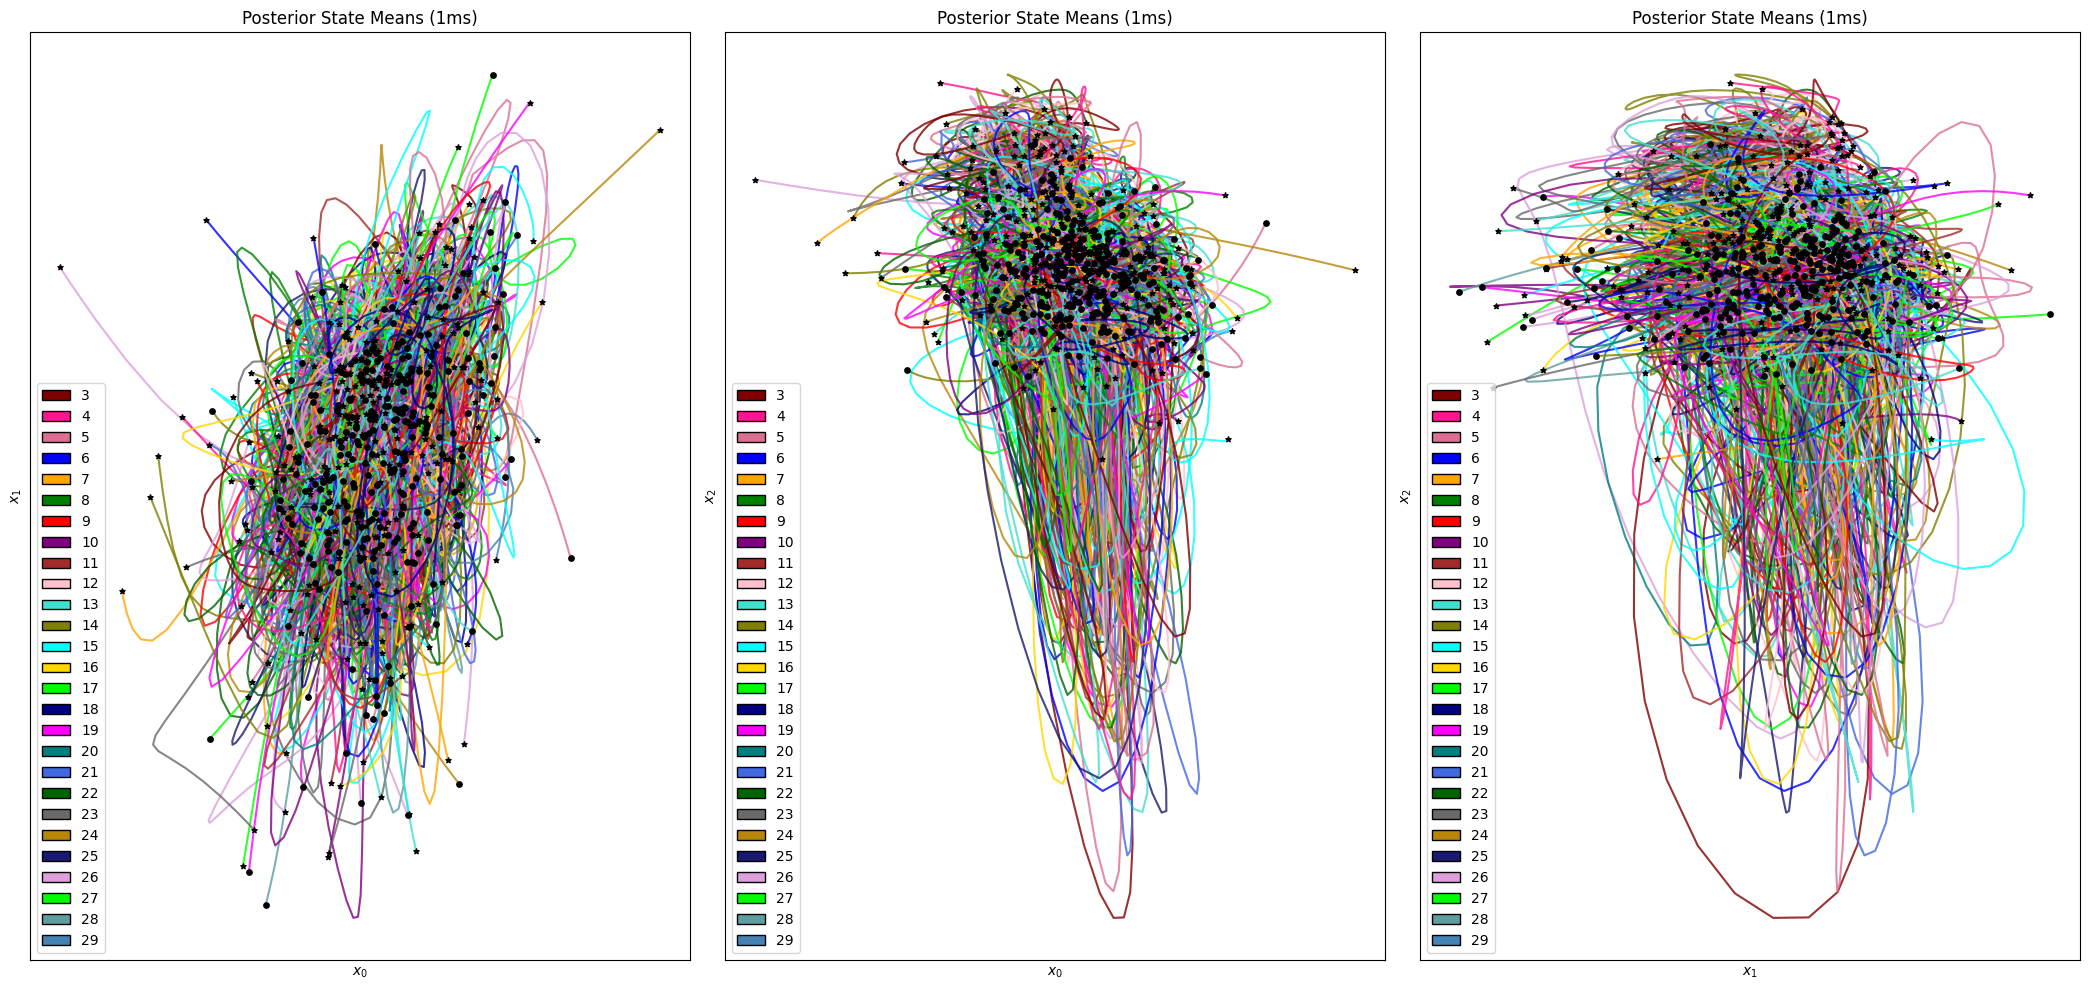

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(21, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, p in enumerate(state_means):

    p = gaussian_filter1d(p, 4, axis=0)

    axes[0].plot(p[:, 0], p[:, 1], c=colors[i], zorder=0, alpha=0.8)

  #  axes[0].scatter(p[0, 0], p[0, 1], s=35, c="black", zorder=1, alpha=1)
    axes[0].scatter(p[0, 0], p[0, 1], s=15, marker='o', c="black", zorder=1, alpha=1)
    axes[0].scatter(p[-1, 0], p[-1, 1], s=15, marker='*', c="black", zorder=1, alpha=1)

    axes[1].plot(p[:, 0], p[:, 2], c=colors[i], zorder=0, alpha=0.8)

    axes[1].scatter(p[0, 0], p[0, 2], s=15, c="black", zorder=1, alpha=1)

    axes[1].scatter(p[-1, 0], p[-1, 2], s=15, marker='*', c="black", zorder=1, alpha=1)

    axes[2].plot(p[:, 1], p[:, 2], c=colors[i], zorder=0, alpha=0.8)

    axes[2].scatter(p[0, 1], p[0, 2], s=15, c="black", zorder=1, alpha=1)
    axes[2].scatter(p[-1, 1], p[-1, 2], s=15, marker='*', c="black", zorder=1, alpha=1)




for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Posterior State Means ({bin_size}ms)")
    ax.legend(handles=custom_patches)


# 0, 0 = x1 vs x2
axes[0].set_xlabel(f"$x_0$")
axes[0].set_ylabel(f"$x_1$")


# 0, 1 = x1 vs x3
axes[1].set_xlabel(f"$x_0$")
axes[1].set_ylabel(f"$x_2$")

# 0, 2 = x2 vs x3
axes[2].set_xlabel(f"$x_1$")
axes[2].set_ylabel(f"$x_2$")

plt.savefig(f"{path}state_means.png")

plt.tight_layout()

# Get the most likely states for each trajectory

In [55]:
discrete_states = list()

for i in range(len(state_means)):
    z_s = plds.most_likely_states(state_means[i], model_data[i])
    discrete_states.append(z_s)

In [56]:
len(discrete_states)

269

In [62]:
discrete_states[0]

array([2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2,
       2, 0, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0,
       2, 2, 2, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0])

In [57]:
# plot each row 
s = np.array(discrete_states)
s.shape

(269, 105)

In [58]:
import matplotlib.colors as mcolors

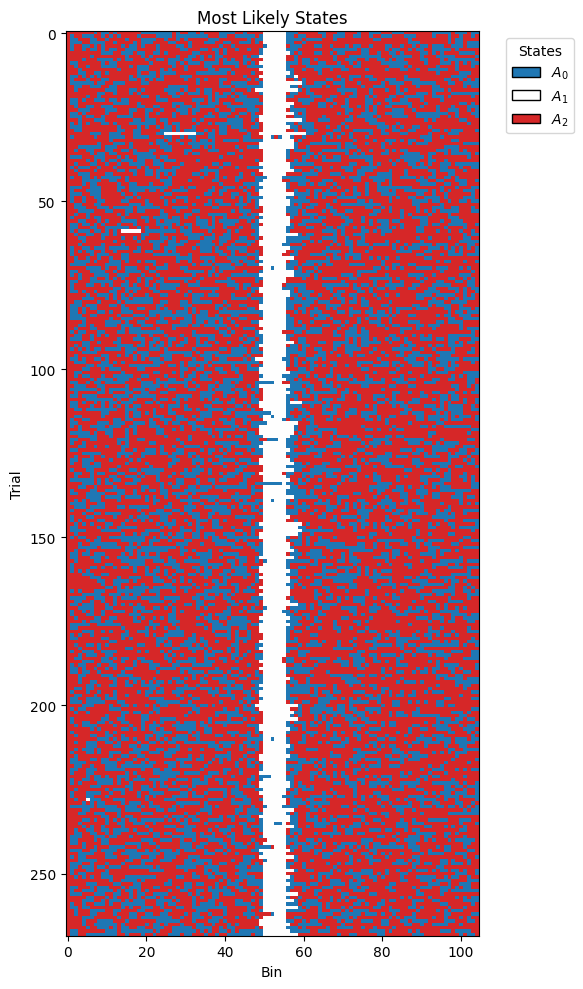

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(6, 10))

color1 = 'tab:blue'
color2 = 'white'
color3 = "tab:red"

# Create the colormap from the list of colors
cmap = mcolors.LinearSegmentedColormap.from_list(
    "ThreeColors", [color1, color2, color3]
)


cax = ax.matshow(s, cmap=cmap, aspect="auto")

plt.tight_layout()

ax.set_xlabel("Bin")
ax.set_ylabel("Trial")

ax.xaxis.set_ticks_position('bottom')

ax.set_title("Most Likely States")

cs = {0: color1, 1: color2, 2: color3}
labels = {0: '$A_0$', 1: '$A_1$', 2: "$A_2$"}

patches = [Patch(facecolor=cs[val], label=labels[val], edgecolor="black")
               for val in sorted(cs.keys())]

plt.legend(handles=patches, title="States", bbox_to_anchor=(1.05, 1), loc='upper left')

#fig.colorbar(cax)

plt.tight_layout()

plt.savefig(f"{path}states.png")

plt.show()

In [196]:
import fastplotlib as fpl
from ipywidgets import IntSlider, Layout, VBox

# Plot state means most likely state z_t

RFBOutputContext()

In [259]:
d = [gaussian_filter1d(p, 4, axis=0) for p in state_means]
d = np.array(d) 
d.shape

(269, 105, 3)

In [260]:
slider = IntSlider(min=0, max=d.shape[1]-1, value=d.shape[1], layout=Layout(width="50%"))

In [286]:
fig = fpl.Figure(cameras="3d")

lc = fig[0, 0].add_line_collection(d)

for i, g in enumerate(lc):
    ms = discrete_states[i] 
    c = list()

    for j in ms:
        if j == 0:
            c.append("magenta")
        else:
            c.append("cyan")
    # ms[np.where(ms == 0)] = "red" 
    # ms[np.where(ms == 1)] = "blue"
    g.colors = c
   # g.cmap = cmap
    #g.cmap.cmap_transform = discrete_states[i]

RFBOutputContext()

In [287]:
def update(ev):
    global lc
    t = ev["new"]

    for g in lc:
        g.colors[:, -1] = 1
        g.colors[t:, -1] = 0

In [288]:
fig[0,0].title = "Posterior State Means"

In [289]:
slider.observe(update, "value")

In [290]:
VBox([fig.show(), slider])

In [291]:
fig.close()

# Plot state means by stim

In [304]:
fig = fpl.Figure(cameras="3d")

RFBOutputContext()

/home/clewis/venvs/bah/lib64/python3.11/site-packages/pygfx/objects/_ruler.py:270: RuntimeWarning: divide by zero encountered in divide
  screen_full = (ndc_full[:, :2] / ndc_full[:, 3:4]) * half_canvas_size
/home/clewis/venvs/bah/lib64/python3.11/site-packages/pygfx/objects/_ruler.py:270: RuntimeWarning: invalid value encountered in divide
  screen_full = (ndc_full[:, :2] / ndc_full[:, 3:4]) * half_canvas_size
/home/clewis/venvs/bah/lib64/python3.11/site-packages/pygfx/objects/_ruler.py:282: RuntimeWarning: invalid value encountered in divide
  screen_sel = (ndc_sel[:, :2] / ndc_sel[:, 3:4]) * half_canvas_size


In [305]:
d = [gaussian_filter1d(p, 4, axis=0) for p in state_means]
d = np.array(d) 
d.shape

(269, 105, 3)

In [306]:
slider = IntSlider(min=0, max=d.shape[1]-1, value=d.shape[1], layout=Layout(width="50%"))

In [307]:
lc = fig[0, 0].add_line_collection(d)


c = ["red"] * 48 + ["white"] * 7 + ["blue"] * 50

for g in lc:
    g.colors = c
  #  g.cmap.cmap_transform = cmap_vals
 #   g.cmap = "viridis"

/home/clewis/venvs/bah/lib64/python3.11/site-packages/fastplotlib/graphics/features/_base.py:18: UserWarning: casting float64 array to float32
  warn(f"casting {array.dtype} array to float32")


In [308]:
def update(ev):
    global lc
    t = ev["new"]

    for g in lc:
        g.colors[:, -1] = 1
        g.colors[t:, -1] = 0

In [309]:
fig[0,0].title = "Posterior State Means"

In [310]:
slider.observe(update, "value")

In [311]:
VBox([fig.show(), slider])

# Plotting B

In [78]:
Bs = plds.dynamics.params[2]
Bs.shape

(3, 3, 144)

In [81]:
Bs[0].shape

(3, 144)

In [79]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import CenteredNorm

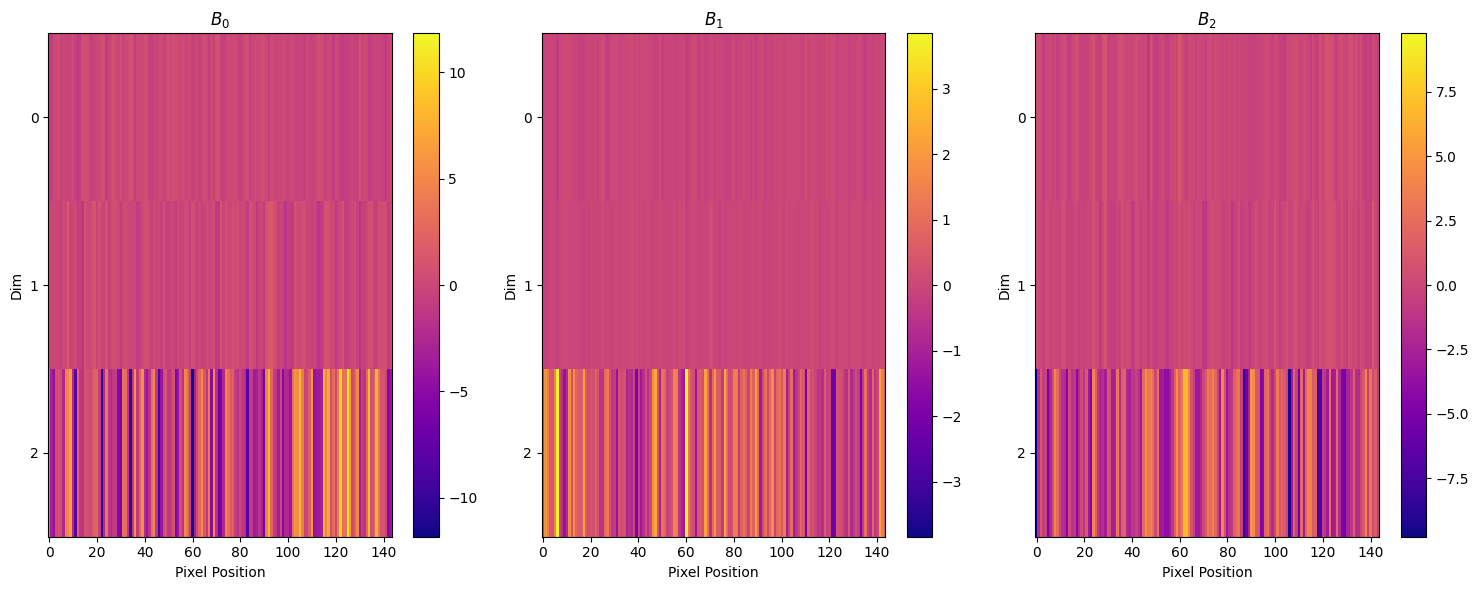

In [102]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, ax in enumerate(axes):
    im = ax.matshow(Bs[i], cmap="plasma", aspect='auto', norm=CenteredNorm())

    ax.set_title(f"$B_{i}$")
    ax.set_ylabel("Dim")
    ax.set_xlabel("Pixel Position")

    ax.xaxis.set_ticks_position('bottom')

    fig.colorbar(im, ax=ax)

plt.tight_layout()

plt.savefig(f"{path}B.png")

plt.show()

In [62]:
Bs.shape

(2, 3, 144)

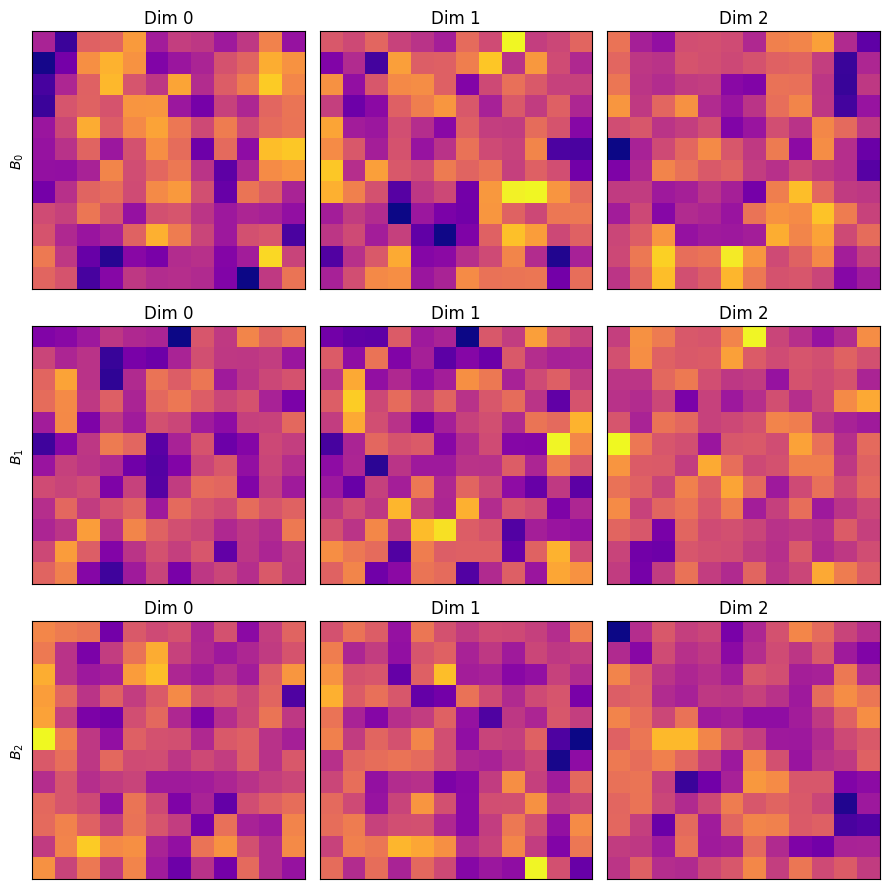

In [84]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i in range(3):
    ax = axes[i]
    ax.matshow(Bs[0][i].reshape(12, 12), cmap='plasma', aspect='auto', norm=CenteredNorm())
    # Create a Rectangle patch with the same dimensions as the image
  #  rect = patches.Rectangle((0, 0), data[i].shape[1] - 1, data[i].shape[0] - 1, linewidth=1, edgecolor='black', facecolor='none')
    
    # Add the patch to the axes
 #   ax.add_patch(rect)
    ax.set_title(f'Dim {i}')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
#    ax.axis('off')  # Turn off axis


for i in range(3):
    ax = axes[i+3]
    ax.matshow(Bs[1][i].reshape(12, 12), cmap='plasma', aspect='auto', norm=CenteredNorm())
    # Create a Rectangle patch with the same dimensions as the image
  #  rect = patches.Rectangle((0, 0), data[i].shape[1] - 1, data[i].shape[0] - 1, linewidth=1, edgecolor='black', facecolor='none')
    
    # Add the patch to the axes
 #   ax.add_patch(rect)
    ax.set_title(f'Dim {i}')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])


for i in range(3):
    ax = axes[i+6]
    ax.matshow(Bs[2][i].reshape(12, 12), cmap='plasma', aspect='auto', norm=CenteredNorm())
    # Create a Rectangle patch with the same dimensions as the image
  #  rect = patches.Rectangle((0, 0), data[i].shape[1] - 1, data[i].shape[0] - 1, linewidth=1, edgecolor='black', facecolor='none')
    
    # Add the patch to the axes
 #   ax.add_patch(rect)
    ax.set_title(f'Dim {i}')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

axes[0].set_ylabel("$B_0$")
axes[3].set_ylabel("$B_1$")
axes[6].set_ylabel("$B_2$")

plt.tight_layout()

plt.savefig(f"{path}B2.png")
plt.show()

# Run lasso regression 

z_{t+1} = Az_t + Bu_t + b

In [85]:
len(state_means)

269

In [86]:
Z_all = np.vstack(state_means)
Z_all.shape

(28245, 3)

In [87]:
U_all = np.vstack(inputs)
U_all.shape

(28245, 144)

In [88]:
from sklearn.linear_model import Lasso

In [89]:
latent_dim = Z_all.shape[1]
input_dim = U_all.shape[1]

In [90]:
B_sparse = np.zeros((latent_dim, input_dim))
alpha = 0.009  # Lasso regularization

for i in range(latent_dim):
    lasso = Lasso(alpha=alpha)
    lasso.fit(U_all, Z_all[:, i])
    B_sparse[i, :] = lasso.coef_

Text(0.5, 1.0, '$B$')

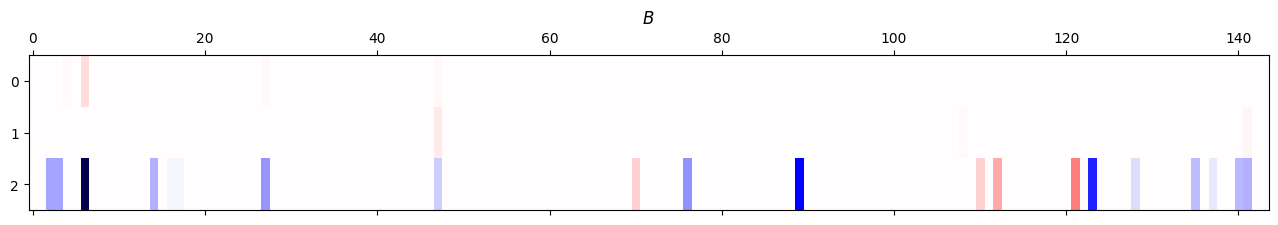

In [91]:
plt.matshow(B_sparse, cmap='seismic', aspect='auto', norm=CenteredNorm())

plt.title("$B$")

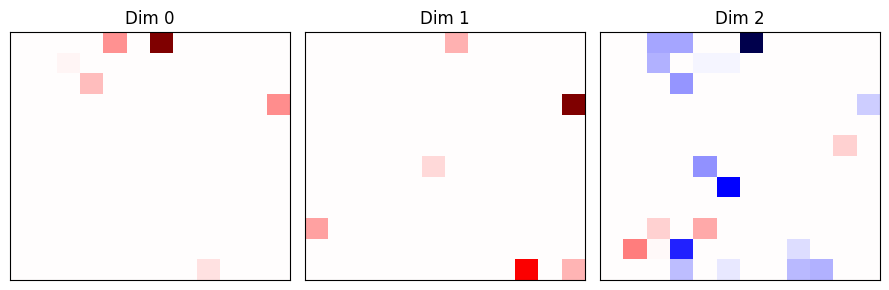

In [92]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i in range(3):
    ax = axes[i]
    ax.matshow(B_sparse[i].reshape(12, 12), cmap='seismic', aspect='auto', norm=CenteredNorm())
    # Create a Rectangle patch with the same dimensions as the image
  #  rect = patches.Rectangle((0, 0), data[i].shape[1] - 1, data[i].shape[0] - 1, linewidth=1, edgecolor='black', facecolor='none')
    
    # Add the patch to the axes
 #   ax.add_patch(rect)
    ax.set_title(f'Dim {i}')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
#    ax.axis('off')  # Turn off axis

plt.tight_layout()

#plt.savefig(f"/home/clewis/repos/realSpike/data/rb50_20250127/plds_stim/pixel/lasso_regression_alpha_{alpha}.png")
plt.savefig(f"{path}B_reduced.png")
plt.show()

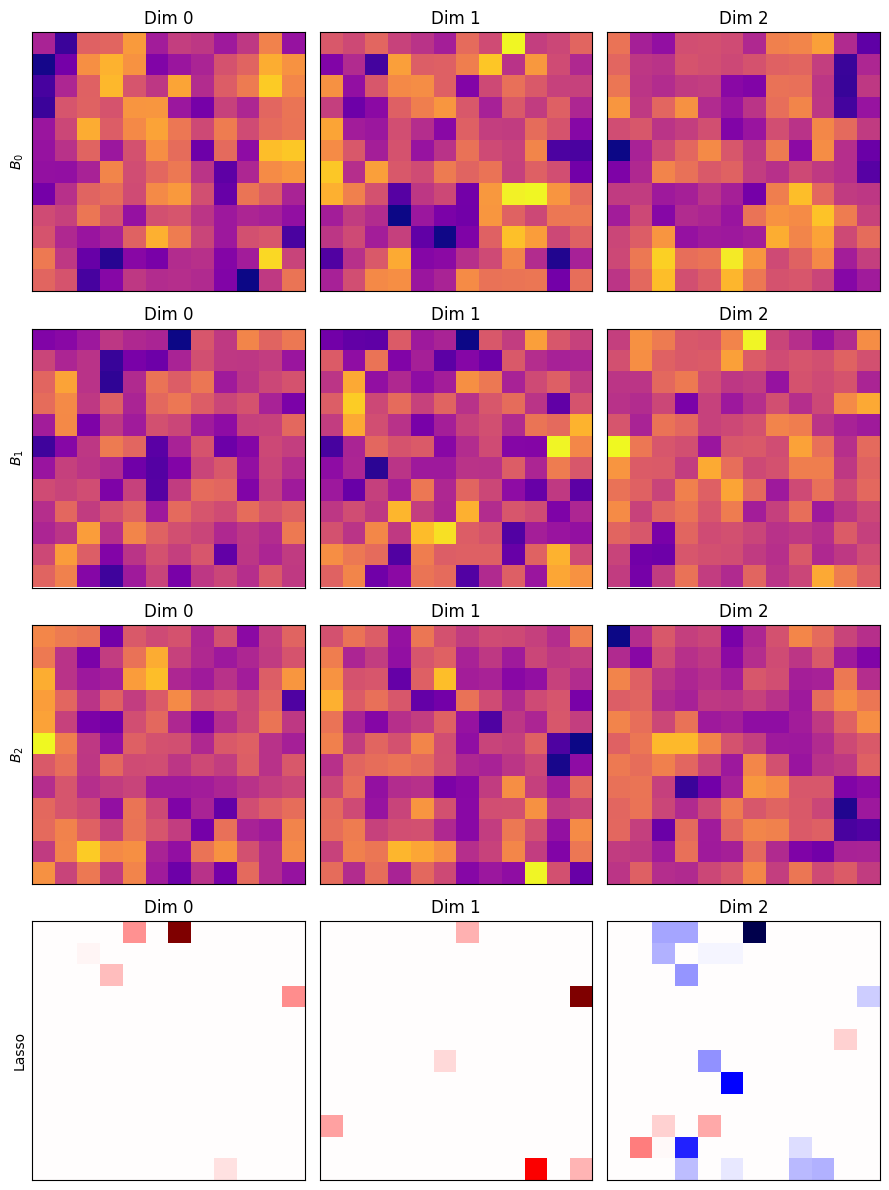

In [93]:
fig, axes = plt.subplots(4, 3, figsize=(9, 12))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i in range(3):
    ax = axes[i]
    ax.matshow(Bs[0][i].reshape(12, 12), cmap='plasma', aspect='auto', norm=CenteredNorm())
    # Create a Rectangle patch with the same dimensions as the image
  #  rect = patches.Rectangle((0, 0), data[i].shape[1] - 1, data[i].shape[0] - 1, linewidth=1, edgecolor='black', facecolor='none')
    
    # Add the patch to the axes
 #   ax.add_patch(rect)
    ax.set_title(f'Dim {i}')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
#    ax.axis('off')  # Turn off axis


for i in range(3):
    ax = axes[i+3]
    ax.matshow(Bs[1][i].reshape(12, 12), cmap='plasma', aspect='auto', norm=CenteredNorm())
    # Create a Rectangle patch with the same dimensions as the image
  #  rect = patches.Rectangle((0, 0), data[i].shape[1] - 1, data[i].shape[0] - 1, linewidth=1, edgecolor='black', facecolor='none')
    
    # Add the patch to the axes
 #   ax.add_patch(rect)
    ax.set_title(f'Dim {i}')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])


for i in range(3):
    ax = axes[i+6]
    ax.matshow(Bs[2][i].reshape(12, 12), cmap='plasma', aspect='auto', norm=CenteredNorm())
    # Create a Rectangle patch with the same dimensions as the image
  #  rect = patches.Rectangle((0, 0), data[i].shape[1] - 1, data[i].shape[0] - 1, linewidth=1, edgecolor='black', facecolor='none')
    
    # Add the patch to the axes
 #   ax.add_patch(rect)
    ax.set_title(f'Dim {i}')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

for i in range(3):
    ax = axes[i+9]
    ax.matshow(B_sparse[i].reshape(12, 12), cmap='seismic', aspect='auto', norm=CenteredNorm())
    # Create a Rectangle patch with the same dimensions as the image
  #  rect = patches.Rectangle((0, 0), data[i].shape[1] - 1, data[i].shape[0] - 1, linewidth=1, edgecolor='black', facecolor='none')
    
    # Add the patch to the axes
 #   ax.add_patch(rect)
    ax.set_title(f'Dim {i}')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
#    ax.axis('off')  # Turn off axis

axes[0].set_ylabel("$B_0$")
axes[3].set_ylabel("$B_1$")
axes[6].set_ylabel("$B_2$")
axes[9].set_ylabel("Lasso")

plt.tight_layout()

plt.savefig(f"{path}B_all.png")
plt.show()